# Imports

In [137]:
from itertools import combinations
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle 
import requests
from scipy import stats
%matplotlib inline

# Methods

In [44]:
def region_maker(state, regions):
    for region in regions:
        if state in regions[region]:
            return region

# Global Constant Stuff

In [80]:
_STATES =  {'Alabama' : 'AL',
'Alaska' : 'AK',
'Arizona' : 'AZ',
'Arkansas' : 'AR',
'California' : 'CA',
'Colorado' : 'CO',
'Connecticut' : 'CT',
'District of Columbia' : 'DC', #This list didn't include DC as a state.... so whoever made this list can fuck off. 
'Delaware' : 'DE',
'Florida' : 'FL',
'Georgia' : 'GA',
'Hawaii' : 'HI',
'Idaho' : 'ID',
'Illinois' : 'IL',
'Indiana' : 'IN',
'Iowa' : 'IA',
'Kansas' : 'KS',
'Kentucky' : 'KY',
'Louisiana' : 'LA',
'Maine' : 'ME',
'Maryland' : 'MD',
'Massachusetts' : 'MA',
'Michigan' : 'MI',
'Minnesota' : 'MN',
'Mississippi' : 'MS',
'Missouri' : 'MO',
'Montana' : 'MT',
'Nebraska' : 'NE',
'Nevada' : 'NV',
'New Hampshire' : 'NH',
'New Jersey' : 'NJ',
'New Mexico' : 'NM',
'New York' : 'NY',
'North Carolina' : 'NC',
'North Dakota' : 'ND',
'Ohio' : 'OH',
'Oklahoma' : 'OK',
'Oregon' : 'OR',
'Pennsylvania' : 'PA',
'Rhode Island' : 'RI',
'South Carolina' : 'SC',
'South Dakota' : 'SD',
'Tennessee' : 'TN',
'Texas' : 'TX',
'Utah' : 'UT',
'Vermont' : 'VT',
'Virginia' : 'VA',
'Washington' : 'WA',
'West Virginia' : 'WV',
'Wisconsin' : 'WI',
'Wyoming' : 'WY'
}

# https://www.nationalgeographic.org/maps/united-states-regions/
_REGIONS = {'south_east' : ['Louisiana', 'Arkansas', 'Mississippi', 'Tennessee', 'Alabama', 
                           'Kentucky', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 
                           'Virginia', 'West Virginia','Delaware'],

           'north_east' : [ 'Maryland', 'New Jersey', 'New York','Connecticut', 'Rhode Island', 'Massachusetts', 
                           'New Hampshire', 'Maine', 'Vermont', 'Pennsylvania'],

           'mid_west' : ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Missouri', 'Iowa',
                         'Wisconsin', 'Illinois', 'Indiana', 'Michigan', 'Ohio' ],

           'west_coast' : ['California', 'Alaska', 'Washington', 'Oregon', 'Nevada', 'Idaho', 'Utah', 'Montana', 
                           'Wyoming', 'Colorado', 'Hawaii'],
            
           'south_west' : ['Arizona', 'New Mexico', 'Texas', 'Oklahoma' ]
}

In [105]:
# Get api key
with open('eia_secret_key.txt', 'r') as f:
    api_key = f.read()

# <span style='color:red'>Load Data</span>

#### <span style='color:red'>DO NOT CALL THIS CELL CALL THE NEXT ONE BELOW!!!!</span>

In [75]:
# DO NOT CALL THIS CELL!!!!!
url =  "https://api.eia.gov/series" 

PARMS = {'api_key': api_key,
         'series_id': 'EMISS.CO2-TOTV-TT-TO-DC.A' 
        }

data = []


#Initialize an empty dataframe to begin
df = pd.DataFrame()

# Call the api multiple times for each state
for state in _STATES.values():
    
    # Reconstruct the series_id string to reflect the state
    PARMS['series_id'] = PARMS['series_id'][:21] + state + '.A'  
    response = requests.get(url, params=PARMS)
    data.append(response)
    

# Iterate through all the responses saved in the list called 'data'
for tmp in data:
    
    #Save the dataframe to a temporary spot called '_'
    _ = pd.DataFrame(tmp.json()['series'][0]['data'], columns = ['Year', 'Carbon_Emissions'])
                     
    # Create a third column called 'State' and set the defualt value to the name of the state                 
    _['State'] = tmp.json()['series'][0]['name'].split(', ')[2]
                     
    #update our main dataframe with additional rows
    df = pd.concat([df, _]) 
    
# Pickle the data for safe keeping
with open('dataframe_pickle', 'ab') as file:
    pickle.dump(df, file)

# <span style='color:green'>Load Data</span>

#### <span style='color:green'>Load the data from the pickles</span>

In [113]:
_  = os.path.join('data', 'dataframe_pickle')
with open(_, 'rb') as file:
    df = pickle.load(file)

In [199]:
_ = os.path.join('data', 'nst-est2019-01.xlsx')
population_df = pd.read_excel(_)

# Explore Data

In [114]:
display(df.head())
display(df.describe().T)
display(df.info())
print('Shape =', df.shape)

,Year,Carbon_Emissions,State
0,2017,109.018634,Alabama
1,2016,114.872696,Alabama
2,2015,120.012608,Alabama
3,2014,123.080771,Alabama
4,2013,120.732885,Alabama


,count,mean,std,min,25%,50%,75%,max
Carbon_Emissions,1900.0,106.007554,108.0786,4.075693,39.883195,75.395415,130.162606,717.958665


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 37
Data columns (total 3 columns):
Year                1900 non-null object
Carbon_Emissions    1900 non-null float64
State               1900 non-null object
dtypes: float64(1), object(2)
memory usage: 59.4+ KB


None

Shape = (1900, 3)


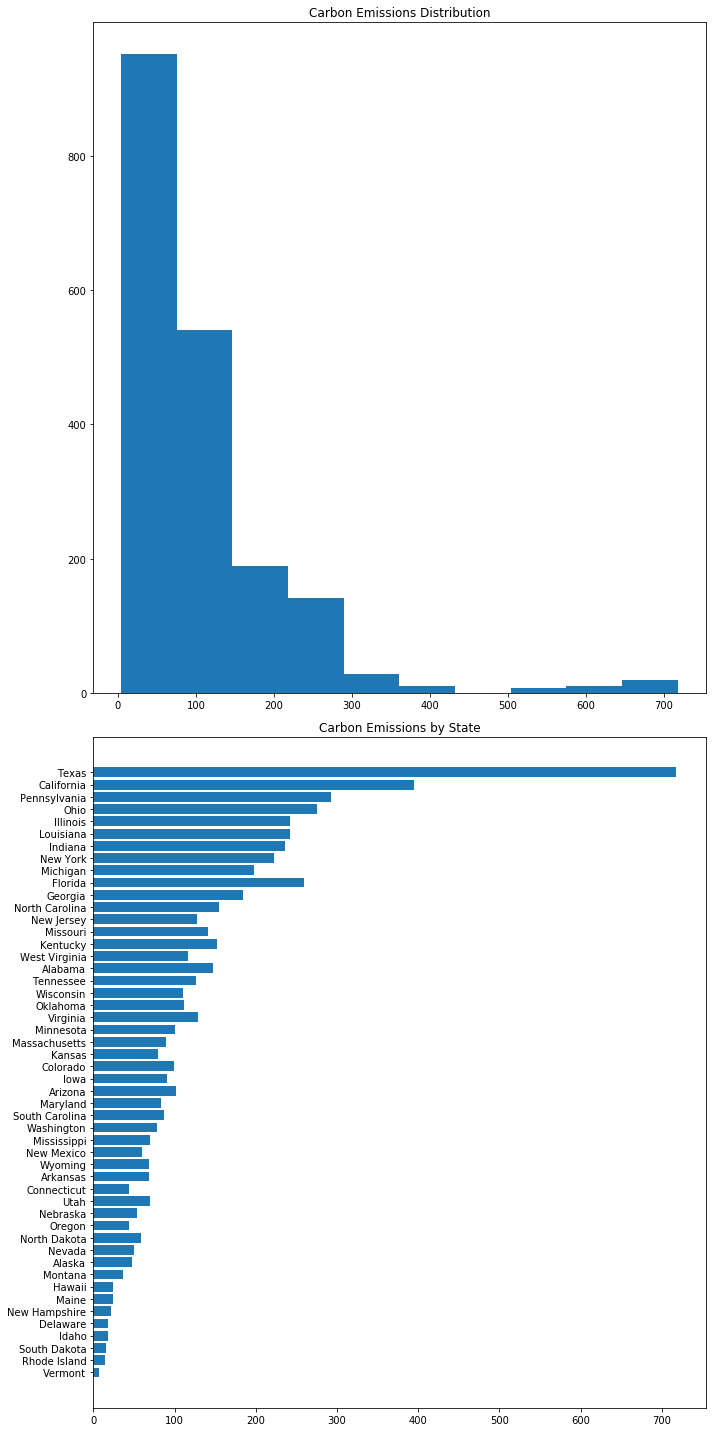

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,20))

axes[0].set_title('Carbon Emissions Distribution')
axes[0].hist(df['Carbon_Emissions'])



axes[1].barh(y=df.sort_values(by=['Carbon_Emissions'])['State'], 
             width=df.sort_values(by=['Carbon_Emissions'])['Carbon_Emissions'])
axes[1].set_title('Carbon Emissions by State')
plt.tight_layout()

# Parse Date

In [63]:
df['Region'] = df['State'].apply(lambda state: region_maker(state, _REGIONS))

# Hypothesis Tests

#### nCk 5 choose 2 combinations of the 'Two Sample T Test'
We compare each regions carbon emissions
    
    Regions: 
        south_east
        north_east 
        mid_west
        west_coast 
        south_west

In [103]:
se = df[df['Region'] == 'south_east']['Carbon_Emissions'].to_numpy()
ne = df[df['Region'] == 'north_east']['Carbon_Emissions'].to_numpy()
mw = df[df['Region'] == 'mid_west']['Carbon_Emissions'].to_numpy()
wc = df[df['Region'] == 'west_coast']['Carbon_Emissions'].to_numpy()
sw = df[df['Region'] == 'south_west']['Carbon_Emissions'].to_numpy()

regions = ['se', 'ne', 'mw', 'wc', 'sw']
nCk_regions = list(combinations(regions, 2))
hypothesis = []

for region_pair in nCk_regions:
    a = region_pair[0]
    b = region_pair[1]
    exec(f"hypothesis.append((stats.ttest_ind({a}, {b}), {region_pair}))")

In [104]:
hypothesis

[(Ttest_indResult(statistic=6.893711798622799, pvalue=1.0424215232592475e-11),
  ('se', 'ne')),
 (Ttest_indResult(statistic=-0.575022916406882, pvalue=0.5654122395052449),
  ('se', 'mw')),
 (Ttest_indResult(statistic=8.345345278748526, pvalue=2.6180733440810227e-16),
  ('se', 'wc')),
 (Ttest_indResult(statistic=-8.544978995639477, pvalue=9.299780244659993e-17),
  ('se', 'sw')),
 (Ttest_indResult(statistic=-6.461243215841171, pvalue=1.7639387634111461e-10),
  ('ne', 'mw')),
 (Ttest_indResult(statistic=1.4888095702730837, pvalue=0.13693358659381277),
  ('ne', 'wc')),
 (Ttest_indResult(statistic=-9.475549831766559, pvalue=8.779131117851111e-20),
  ('ne', 'sw')),
 (Ttest_indResult(statistic=7.833561267591102, pvalue=1.3760091344898568e-14),
  ('mw', 'wc')),
 (Ttest_indResult(statistic=-7.699637066159663, pvalue=5.5785144003489376e-14),
  ('mw', 'sw')),
 (Ttest_indResult(statistic=-10.198240147246846, pvalue=1.5380489576177303e-22),
  ('wc', 'sw'))]

In [247]:
population_df.head(10)

States,Year,United States,Northeast,Midwest,South,West,Alabama,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2010,309321666,55380134,66974416,114866680,72100436,4785437,713910,6407172,2921964,...,816166,6355311,25241971,2775332,625879,8023699,6742830,1854239,5690475,564487
1,2011,3.11557e+08,5.56042e+07,6.71578e+07,1.16007e+08,7.27883e+07,4.79907e+06,722128,6.47264e+06,2.94067e+06,...,823579,6.39929e+06,2.56456e+07,2.81438e+06,627049,8.10116e+06,6.82663e+06,1.8563e+06,5.70529e+06,567299
2,2012,3.13831e+08,5.57752e+07,6.73367e+07,1.17241e+08,7.34778e+07,4.81559e+06,730443,6.55498e+06,2.95216e+06,...,833566,6.4539e+06,2.60845e+07,2.85338e+06,626090,8.18508e+06,6.89706e+06,1.85687e+06,5.71996e+06,576305
3,2013,3.15994e+08,5.59018e+07,6.75604e+07,1.18364e+08,7.41671e+07,4.83008e+06,737068,6.63276e+06,2.9594e+06,...,842316,6.49434e+06,2.64803e+07,2.89764e+06,626210,8.25243e+06,6.96398e+06,1.85391e+06,5.73675e+06,582122
4,2014,3.18301e+08,5.6006e+07,6.77452e+07,1.19624e+08,7.49258e+07,4.8418e+06,736283,6.73041e+06,2.96739e+06,...,849129,6.54122e+06,2.69643e+07,2.93688e+06,625214,8.31099e+06,7.05466e+06,1.84949e+06,5.75152e+06,582531
5,2015,3.20635e+08,5.60347e+07,6.78606e+07,1.20997e+08,7.57426e+07,4.85235e+06,737498,6.82968e+06,2.97805e+06,...,853988,6.59117e+06,2.74701e+07,2.98184e+06,625216,8.36181e+06,7.16366e+06,1.84205e+06,5.76094e+06,585613
6,2016,3.22941e+08,5.60423e+07,6.79875e+07,1.22352e+08,7.65597e+07,4.86352e+06,741456,6.94107e+06,2.98992e+06,...,862996,6.64601e+06,2.79144e+07,3.04187e+06,623657,8.41011e+06,7.29477e+06,1.83102e+06,5.77263e+06,584215
7,2017,3.24986e+08,5.60592e+07,6.81268e+07,1.23542e+08,7.72573e+07,4.87449e+06,739700,7.04401e+06,3.00134e+06,...,872868,6.7088e+06,2.82953e+07,3.10104e+06,624344,8.46359e+06,7.42336e+06,1.817e+06,5.79019e+06,578931
8,2018,3.26688e+08,5.60466e+07,6.82366e+07,1.24569e+08,7.78348e+07,4.88768e+06,735139,7.15802e+06,3.00973e+06,...,878698,6.77163e+06,2.86287e+07,3.15355e+06,624358,8.50129e+06,7.52387e+06,1.80429e+06,5.80741e+06,577601
9,2019,3.2824e+08,5.59828e+07,6.8329e+07,1.2558e+08,7.83473e+07,4.90318e+06,731545,7.27872e+06,3.0178e+06,...,884659,6.82917e+06,2.89959e+07,3.20596e+06,623989,8.53552e+06,7.61489e+06,1.79215e+06,5.82243e+06,578759


In [200]:
population_df.columns = population_df.iloc[2]

population_df.rename(columns = {np.nan: 'States',         
                                'Census': 'Census', 
                                'Estimates Base': 'Estimates Base',             
                                2010 : 2010,
                                2011.0 : 2011,
                                2012.0 : 2012,
                                2013.0 : 2013,
                                2014.0 : 2014,
                                2015.0 : 2015,           
                                2016.0 : 2016,           
                                2017.0 : 2017,           
                                2018.0 : 2018,
                                2019.0 : 2019 
                               }, 
                     inplace=True)

population_df.drop(range(3), inplace=True)

population_df.drop(list(range(59, 66)), inplace=True)

population_df['States'] = population_df['States'].map(lambda x: x.replace('.', ''))

population_df = population_df.T

population_df.columns = population_df.iloc[0]

population_df.reset_index(inplace = True)

population_df.rename(columns = {2: 'Year'}, inplace =True)

population_df.drop(range(3), inplace = True)

population_df.reset_index(inplace = True)

population_df.drop(columns=['index'], inplace=True)

population_df.index.name = None

population_df.columns = population_df.columns.get_level_values(0)